# Classifying names using RNN

## Data preparation

In [91]:
# Importing libaries

from io import open
import unicodedata
import string
import glob
import os


def find_files(path: str):
  ''' Return all availble files that have a .txt extension, from the given path.'''
  return glob.glob(path)


# Combining the ascii character with some other characters.
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )
# print(unicode_to_ascii('Ślusàrski')) -> Slusarski


def read_lines(filename):
  '''Read a file, convert all text to plain ASCII and return as words in a list.'''
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]



# Build a vocabulary_line dictionary,
# mapping multiples names (item) to country (key). example {'country_code': [names]}
category_lines = {}
all_categories = []
path = '/content/drive/MyDrive/Colab_Notebooks/So_help_me_God/common_countries_name/*.txt'

for filename in find_files(path):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = read_lines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

Country names and their short code
```
Burundi:      BI             
Bostwana:     BW             
Burkina Faso: BF
Cameroon:     CA             
Djibouti:     DJ              
Ghana:        GH                
Namibia:      NA              
Nigeria:      NG              
South Africa: ZA
```

In [92]:
all_categories

['DJ', 'ZA', 'NG', 'GH', 'NA', 'CA', 'BF', 'BW', 'BI']

In [93]:
print(category_lines['NG'][:5])

['Alh', 'Dan', 'Nura', 'Bernard', 'Nasiru']


## Turning names into Tensors

In [94]:
import torchtext, torch

def letter_to_index(letter):
  '''Returns the index of a single passed character/letter.'''
  return all_letters.find(letter)

def letter_to_tensor(letter):
  '''One hot encoding. example [0,0,0,1,0,0] where only one index gets 1 rest is 0.'''
  tensor = torch.zeros(1, n_letters)
  tensor[0][letter_to_index(letter)] = 1
  return tensor


def line_to_tensor(line):
  '''Turn a name into tensor'''
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letter_to_index(letter)] = 1
  return tensor

# In each dimension only one index becomes 1, rest is 0.
line_to_tensor('Ada')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

# Creating the Network

In [95]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined) # shape torch.Size([1, input+hidden])
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) # n_letter(57 characters) as input, n_categories: numbers of countries to predict

## Running a single pass
in this step only one value in the name is passed through the model.


In [96]:
input = line_to_tensor('Daniel') # torch.Size([6, 1, 56])
print(input[0].shape) # 'D' torch.Size([1, 56])
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden) # forward pass
output # Propabilities prediction of each countries.

torch.Size([1, 57])


tensor([[-2.1117, -2.2411, -2.1875, -2.2576, -2.0813, -2.2079, -2.2363, -2.2232,
         -2.2442]], grad_fn=<LogSoftmaxBackward0>)

## Training

In [97]:
def category_from_output(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

category_from_output(output)

('NA', 4)

## Returns a random training example

In [98]:
import random

def random_choice(l):
  '''returns a random character from l, based on indexing.'''
  return l[random.randint(0, len(l)-1)]

def random_training_example():
  '''Returns a random training example.'''
  category = random_choice(all_categories)
  line = random_choice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)],
                                 dtype=torch.long)
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = random_training_example()
  print(category, line, category_tensor.item(), line_tensor.shape)

NA Quinton 4 torch.Size([7, 1, 57])
DJ Hawa Noura 0 torch.Size([10, 1, 57])
BF Lofo 6 torch.Size([4, 1, 57])
BW Thembie 7 torch.Size([7, 1, 57])
CA Shannon 5 torch.Size([7, 1, 57])
GH Becca 3 torch.Size([5, 1, 57])
BW Buyani 7 torch.Size([6, 1, 57])
NG Nwankwo 2 torch.Size([7, 1, 57])
BF Lankoande 6 torch.Size([9, 1, 57])
DJ Nicky Manaj 0 torch.Size([11, 1, 57])


## Training the network

In [99]:
criterion = nn.NLLLoss() # loss fn
learning_rate = 0.005

def train(category_tensor, line_tensor):
  """
  Train the model given a name (e.g., 'Daniel') through individual characters.
  Indexing through line_tensor[i] from [len(name), 1, n_characters_general].
  """
  hidden = rnn.init_hidden() # give hidden unit the extra dimension

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden) # passing [1, 57] each loop/each character at a time.

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [100]:
import time, math

n_iters = 100000
print_every = 5_000
plot_every = 1_000

# keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return f'{m}m {s:.0f}s'


start = time.time()
for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = random_training_example()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = category_from_output(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print(f'{iter} {iter / n_iters * 100:.0f}% ({time_since(start)}) {loss:.4f} {line} {guess} / {correct}')
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 8s) 2.1856 Esther DJ / ✗ (GH)
10000 10% (0m 16s) 2.0836 Nicaise Dg DJ / ✗ (BF)
15000 15% (0m 25s) 0.6880 Mamoud Abasse BF / ✓
20000 20% (0m 33s) 0.8409 Adrien CA / ✓
25000 25% (0m 41s) 1.9899 Loretta NA / ✗ (GH)
30000 30% (0m 49s) 1.0468 Ravneet CA / ✓
35000 35% (0m 57s) 1.4763 Akuba NA / ✗ (GH)
40000 40% (1m 5s) 2.0671 Botswana GH / ✗ (BW)
45000 45% (1m 13s) 0.9613 Zougounoma BF / ✓
50000 50% (1m 21s) 1.9065 Katoum GH / ✗ (DJ)
55000 55% (1m 30s) 1.8356 Nonnie ZA / ✗ (BW)
60000 60% (1m 39s) 1.9596 James NA / ✗ (NG)
65000 65% (1m 47s) 2.4541 Lazarus NA / ✗ (NG)
70000 70% (1m 56s) 2.5968 Aghogho BW / ✗ (NG)
75000 75% (2m 3s) 2.1163 Irene CA / ✗ (ZA)
80000 80% (2m 12s) 3.3071 Paulos BF / ✗ (ZA)
85000 85% (2m 19s) 0.6485 Sakyiwaa GH / ✓
90000 90% (2m 27s) 1.7348 Baaba BF / ✗ (GH)
95000 95% (2m 35s) 1.9230 Ghassane BW / ✗ (BF)
100000 100% (2m 43s) 2.0981 Itz NG / ✗ (GH)


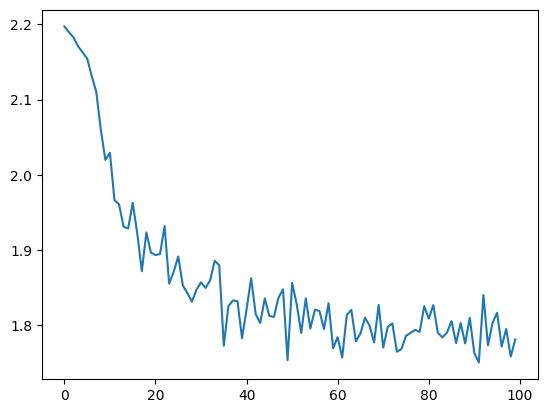

In [101]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate the results

In [102]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10_000

def evaluate(line_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

def predict(input_line, n_predictions=3):
  print(f'\n {input_line}')

  with torch.no_grad(): # we are no longer training, but evaluating
    output = evaluate(line_to_tensor(input_line))

    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s' % (value, all_categories[category_index]))
      predictions.append([value, all_categories[category_index]])

In [106]:
predict('Ade')


 Ade
(-1.68) NG
(-1.84) GH
(-1.89) CA
